### 通过LSTM来预测未来航班的乘客数

In [15]:
import numpy as np
import pandas as pd

#### 首先需要读数据这里只取乘客数

In [218]:
dataframe=pd.read_csv('data/international-airline-passengers.csv',usecols=[1])

In [219]:
dataframe

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121
5,135
6,148
7,148
8,136
9,119


#### 接下来需要将数据转换为浮点数数组以便后来送进神经网络进行学习

In [216]:
dataset=dataframe.values
dataset=dataframe.astype('float32')

In [217]:
dataset

array([[112],
       [118],
       [132],
       [129],
       [121],
       [135],
       [148],
       [148],
       [136],
       [119],
       [104],
       [118],
       [115],
       [126],
       [141],
       [135],
       [125],
       [149],
       [170],
       [170],
       [158],
       [133],
       [114],
       [140],
       [145],
       [150],
       [178],
       [163],
       [172],
       [178],
       [199],
       [199],
       [184],
       [162],
       [146],
       [166],
       [171],
       [180],
       [193],
       [181],
       [183],
       [218],
       [230],
       [242],
       [209],
       [191],
       [172],
       [194],
       [196],
       [196],
       [236],
       [235],
       [229],
       [243],
       [264],
       [272],
       [237],
       [211],
       [180],
       [201],
       [204],
       [188],
       [235],
       [227],
       [234],
       [264],
       [302],
       [293],
       [259],
       [229],
       [203],
      

In [27]:
dataset.shape

(144, 1)

#### 这里可以将数据展示一下

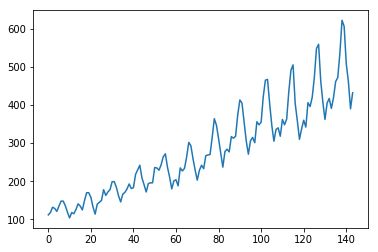

In [28]:
import matplotlib.pyplot as plt
plt.plot(dataset)
plt.show()

#### 从上图中我们可以看出，乘客数目还是有一定的规律每年也有高峰期和低峰期

### 接下来就是重中之重对数据进行划分和操作了，首先是标准化数据，并将数据划分为训练集、验证集合测试集神经网络对数据很敏感，神经网络喜欢小数据特别使用sigmoid或者tanh激活函数时候，所以我们将数据调整到0到1的范围（标准化）是最好的做法

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))#使用sklearn工具将属性缩放到(0,1)之间的值
dataset=scaler.fit_transform(dataset)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [36]:
dataset#可以看出数据已经缩放到0-1之间了

array([[0.01544402],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857],
       [0.05984556],
       [0.04054054],
       [0.08687259],
       [0.12741313],
       [0.12741313],
       [0.1042471 ],
       [0.05598456],
       [0.01930502],
       [0.06949807],
       [0.07915058],
       [0.08880309],
       [0.14285714],
       [0.11389961],
       [0.13127413],
       [0.14285714],
       [0.18339768],
       [0.18339768],
       [0.15444015],
       [0.11196911],
       [0.08108108],
       [0.11969112],
       [0.12934363],
       [0.14671815],
       [0.17181467],
       [0.14864865],
       [0.15250965],
       [0.22007722],
       [0.24324324],
       [0.26640927],
       [0.2027027 ],
       [0.16795367],
       [0.13127413],
       [0.173

In [47]:
dataset[0:1,0].shape

(1,)

#### 接下来按照黄金比例进行数据划分，这里将67%的数据作为训练数据，剩下的33%作为测试数据

In [172]:
train_size=int(len(dataset)*0.67)
test_size=len(dataset)-train_size
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]

#### 我们将数据打出来看看

In [183]:
train.shape,test.shape

((96, 1), (48, 1))

In [39]:
train.shape,test.shape

((96, 1), (48, 1))

### 接下来我们定义生成样本的函数，将数据存储为两个矩阵，一个矩阵的ind位置存储t时刻的值，另一个矩阵存储t+1时刻的值

In [48]:
import numpy as np
def create_dataset(dataset,look_back=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back),0])
        dataY.append(dataset[i+look_back,0])
    return np.array(dataX),np.array(dataY)

#### 这里说明一下怎么划分数据，这里是基于历史数据预测下一个时刻的数据，这里需要决定每次依赖多少历史数据，这里设置参数look_back=1设置的历史数据为1，也就是基于前一个月数据预测下一个月份的数据。这里我们以前一个月的值预测下一个月的乘客数，预测下一个月的值会有偏差，当然这也是是我们神经网络要做的，后面我们会用均方根误差来衡量模型真实输出和这个值得差距。但是测试数据没有必要这样划分，因为他不需要标签，这里分的意思是利用分到的标签用于计算模型在测试数据上的均值根误差

In [49]:
look_back=1
trainX,trainY=create_dataset(train,look_back)
testX,testY=create_dataset(test,look_back)

In [53]:
trainX.shape,testX.shape

((94, 1), (46, 1))

#### 接下来也非常关键因为神经网络对输入尺寸要求非常严格，我们必须调整数据尺寸后才能送进神经网络进行计算，对于LSTM要求的固定格式是[samples,time_steps,features]，所以我们必须把数据调整成这样的格式:samples表示的是样本数，time_steps是时间序列，features是样本的特征，这里我们做如下的调整。

In [54]:
trainX=np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX=np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

In [55]:
trainX.shape,testX.shape

((94, 1, 1), (46, 1, 1))

### 接下来就是构建模型，这里使用LSTM(短时期记忆网络)

In [209]:
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM 
from keras.utils import plot_model 
from IPython.display import SVG 
from keras.utils.vis_utils import model_to_dot 
from keras.layers import GRU,Bidirectional
from keras.optimizers import RMSprop

In [210]:
# 构建LSTM网络结构
model=Sequential()
model.add(LSTM(8,input_shape=(1,look_back)))
model.add(Dense(1))

#### 这里编译损失函数采用mse，经过实测采用mse的效果要好于mae的效果

In [211]:
model.compile(loss='mean_squared_error',optimizer=RMSprop())

#### 这里将模型结构和规模可视化一下

In [212]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [213]:
from keras.utils import plot_model
plot_model(model,to_file='lstm.png',show_shapes=True)

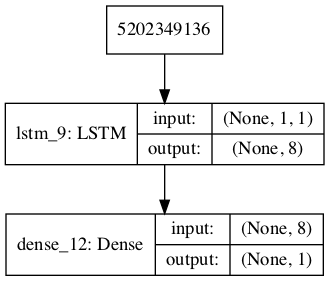

In [214]:
from IPython.display import Image
Image(filename="lstm.png")

#### 从上图可以看出模型还是非常小的，下面开始训练模型

In [215]:
history=model.fit(trainX,trainY,epochs=50,batch_size=1,verbose=1)

Epoch 1/50
94/94 [==============================] - 2s 18ms/step - loss: 0.0439
Epoch 2/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 3/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 4/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 5/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 6/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 7/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 8/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 9/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 10/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 11/50
94/94 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 12/50
94/94 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 13/50
94/94 [=============================

#### 这里将训练曲线可视化一下

In [125]:
def draw_roc(history):
    train_loss=history.history['loss']
    epochs=range(0,len(train_loss))
    plt.figure()
    plt.title("Training Loss")
    plt.plot(epochs,train_loss,'r',label='loss')
    plt.legend()
    plt.show()

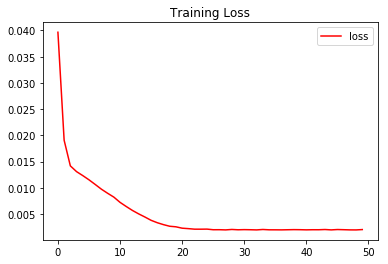

In [126]:
draw_roc(history)

#### 从训练曲线可以看出模型在30次后损失函数就不再下降了，所以我们可以降低迭代次数

### 接下来我们看看模型的具体结果

In [142]:
trainPredict=model.predict(trainX)
testPredict=model.predict(testX)

In [143]:
trainPredict

array([[0.03904074],
       [0.04843372],
       [0.07077863],
       [0.06594109],
       [0.05317204],
       [0.07564246],
       [0.09701464],
       [0.09701464],
       [0.07726952],
       [0.05001009],
       [0.02669388],
       [0.04843372],
       [0.04372317],
       [0.06113018],
       [0.08544765],
       [0.07564246],
       [0.05953252],
       [0.09867802],
       [0.13421308],
       [0.13421308],
       [0.11376866],
       [0.072397  ],
       [0.04215922],
       [0.08380637],
       [0.09204078],
       [0.10034412],
       [0.14803733],
       [0.12224335],
       [0.13765496],
       [0.14803733],
       [0.18500677],
       [0.18500677],
       [0.1585025 ],
       [0.12054335],
       [0.093696  ],
       [0.12735844],
       [0.13593282],
       [0.15151668],
       [0.17434855],
       [0.15325975],
       [0.1567527 ],
       [0.21921435],
       [0.2411417 ],
       [0.26328713],
       [0.20292792],
       [0.1708123 ],
       [0.13765496],
       [0.176

#### 上面的预测值都是[0,1]这样的标准化数据，我们需要将它们转换为原始值，这里使用inverse_transform这个API

In [155]:
trainPredict_real=scaler.inverse_transform(trainPredict)
testPredict_real=scaler.inverse_transform(testPredict)

In [156]:
trainPredict_real

array([[124.22311 ],
       [129.08867 ],
       [140.66333 ],
       [138.15749 ],
       [131.54312 ],
       [143.1828  ],
       [154.25359 ],
       [154.25359 ],
       [144.0256  ],
       [129.90523 ],
       [117.82744 ],
       [129.08867 ],
       [126.648605],
       [135.66544 ],
       [148.26189 ],
       [143.1828  ],
       [134.83784 ],
       [155.11522 ],
       [173.52238 ],
       [173.52238 ],
       [162.93216 ],
       [141.50163 ],
       [125.83848 ],
       [147.4117  ],
       [151.67712 ],
       [155.97826 ],
       [180.68333 ],
       [167.32205 ],
       [175.30527 ],
       [180.68333 ],
       [199.8335  ],
       [199.8335  ],
       [186.10431 ],
       [166.44145 ],
       [152.53453 ],
       [169.97166 ],
       [174.41321 ],
       [182.48564 ],
       [194.31255 ],
       [183.38855 ],
       [185.1979  ],
       [217.55302 ],
       [228.9114  ],
       [240.38274 ],
       [209.11665 ],
       [192.48077 ],
       [175.30527 ],
       [195.2

In [157]:
trainY_real=scaler.inverse_transform([trainY])
testY_real=scaler.inverse_transform([testY])

### 这里要计算出预测的均方根误差

In [158]:
import math
from sklearn.metrics import mean_squared_error 
trainScore=math.sqrt(mean_squared_error(trainY_real[0],trainPredict_real[:,0]))

In [159]:
trainScore

22.98303780418869

In [160]:
testScore=math.sqrt(mean_squared_error(testY_real[0],testPredict_real[:,0]))

In [161]:
testScore

48.01094086178077

#### 下面将整个预测的结果可视化一下

In [162]:
trainPredictPlot=np.empty_like(dataset)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(trainPredict_real)+look_back,:]=trainPredict_real

In [169]:
#对测试数据也可视化一下
testPredictPlot=np.empty_like(dataset)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(trainPredict_real)+look_back:len(dataset)-3,:]=testPredict_real

#### 显示图片

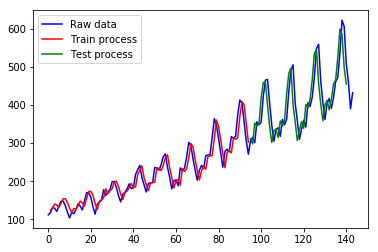

In [170]:
# 显示图片 
plt.plot(scaler.inverse_transform(dataset),color='blue',label='Raw data') 
plt.plot(trainPredictPlot,color='red',label='Train process') 
plt.plot(testPredictPlot,color='green',label='Test process') 
plt.legend(loc='best')
plt.show()

#### 从上面的曲线我们可以看出模型的拟合能力还是很强的预测的值差距很小

In [174]:
test[-1]

array([0.63320463])

#### 接下来就是预测一下数据，这里一定要将数据转换一下，数据怎么进神经网络的。要预测的数据也要怎么进神经网络

In [175]:
def model_predict(data):
    predictX=np.reshape(data,(1,1,testX.shape[1]))
    #预测得到标准化数据
    featruePredict=model.predict(predictX)
    #将标准化的数字转换为实际人数
    featruePredict=scaler.inverse_transform(featruePredict)
    return featruePredict

In [220]:
model_predict(test[-1])

array([[416.5474]], dtype=float32)

In [182]:
model_predict(np.array(432))

array([[1157.9958]], dtype=float32)

In [184]:
test.shape

(48, 1)

In [194]:
test1=scaler.inverse_transform(test)

In [195]:
test1

array([[315.],
       [301.],
       [356.],
       [348.],
       [355.],
       [422.],
       [465.],
       [467.],
       [404.],
       [347.],
       [305.],
       [336.],
       [340.],
       [318.],
       [362.],
       [348.],
       [363.],
       [435.],
       [491.],
       [505.],
       [404.],
       [359.],
       [310.],
       [337.],
       [360.],
       [342.],
       [406.],
       [396.],
       [420.],
       [472.],
       [548.],
       [559.],
       [463.],
       [407.],
       [362.],
       [405.],
       [417.],
       [391.],
       [419.],
       [461.],
       [472.],
       [535.],
       [622.],
       [606.],
       [508.],
       [461.],
       [390.],
       [432.]])